<a href="https://colab.research.google.com/github/PratyushNag/Music-Generator-v1/blob/main/Music_Generation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collecting Data

In [ ]:
from google.colab import files
! pip install -q kaggle
#upload kaggle.json
files.upload()

In [4]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d imsparsh/lakh-midi-clean
!kaggle datasets download -d soumikrakshit/classical-music-midi

In [ ]:
! mkdir Midi
#! unzip lakh-midi-clean.zip -d Midi
! unzip classical-music-midi.zip -d Midi_classical

# Installing dependencies and imports

In [8]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
!pip install display

In [ ]:
!pip install pyyaml h5py

In [13]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import pretty_midi
import fluidsynth
from IPython.display import display, Audio
import collections
from typing import Optional
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.layers import Dense, LSTM, Dropout, MaxPooling1D, Flatten, AveragePooling1D, AveragePooling2D, MaxPooling2D, Bidirectional
from keras.losses import BinaryCrossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences

In [14]:
#setting seed for randomness
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Data Munging

Mapping the data onto a dataframe for easy viewing acess

In [15]:
paths = []
for dirname, _, filenames in os.walk('Midi_classical'):
    for filename in filenames:
        if filename.lower().endswith(".mid"):
            paths.append(os.path.join(dirname, filename))

In [16]:
midi_df = pd.DataFrame()
midi_df['midi'] = paths
midi_df.head()

,midi
0,Midi_classical/beeth/mond_1.mid
1,Midi_classical/beeth/beethoven_opus10_1.mid
2,Midi_classical/beeth/beethoven_opus90_2.mid
3,Midi_classical/beeth/appass_1.mid
4,Midi_classical/beeth/mond_2.mid


In [17]:
midi_df.shape

(295, 1)

In [18]:
#converting a sample MIDI file into a playable file using the pretty midi library
pm = pretty_midi.PrettyMIDI(midi_df.loc[3, 'midi'])

In [19]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display(Audio(waveform_short, rate=_SAMPLING_RATE))

In [20]:
display_audio(pm)

In [21]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 2
Instrument name: Acoustic Grand Piano


In [22]:
# function to convert MIDI file into it's specific notes, so its easier for user to view
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        instrument = pm.instruments[0]
        notes = collections.defaultdict(list)

        # Sort the notes by start time
        sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
        prev_start = sorted_notes[0].start
        #Here we split the data into three respective features
        #pitch = note pressed (represented in numerical format)
        #step = when the note is pressed, w.r.t the last note
        #duration = how long the note is pressed for
        for note in sorted_notes:
            start = note.start
            end = note.end
            notes['pitch'].append(note.pitch)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)
            prev_start = start

        return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

    except Exception as e:
        print(f"Error processing file {midi_file}: {str(e)}")
        return None

In [23]:
raw_notes = midi_to_notes(midi_df.loc[3, 'midi'])
raw_notes.head()

,pitch,start,end,step,duration
0,60,1.628172,2.146812,0.000000,0.518640
1,56,2.146812,2.283411,0.518640,0.136599
2,53,2.283411,3.952758,0.136599,1.669347
3,56,3.952758,4.430089,1.669347,0.477331
4,60,4.430089,4.537516,0.477331,0.107427


In [24]:
#adding a column 'note' converting respective pitches into understandable music notes
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
raw_notes['note'] = get_note_names(raw_notes['pitch'])
raw_notes

,pitch,start,end,step,duration,note
0,60,1.628172,2.146812,0.000000,0.518640,C4
1,56,2.146812,2.283411,0.518640,0.136599,G#3
2,53,2.283411,3.952758,0.136599,1.669347,F3
3,56,3.952758,4.430089,1.669347,0.477331,G#3
4,60,4.430089,4.537516,0.477331,0.107427,C4
...,...,...,...,...,...,...
3202,68,556.130955,556.248752,0.108496,0.117798,G#4
3203,72,556.248752,556.371713,0.117798,0.122961,C5
3204,68,556.371713,556.642032,0.122961,0.270319,G#4
3205,68,556.642032,558.899088,0.270319,2.257056,G#4


## Visualising the given data

In [25]:
#function to plot a piano roll graph from the given MIDI file for visualization purposes
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

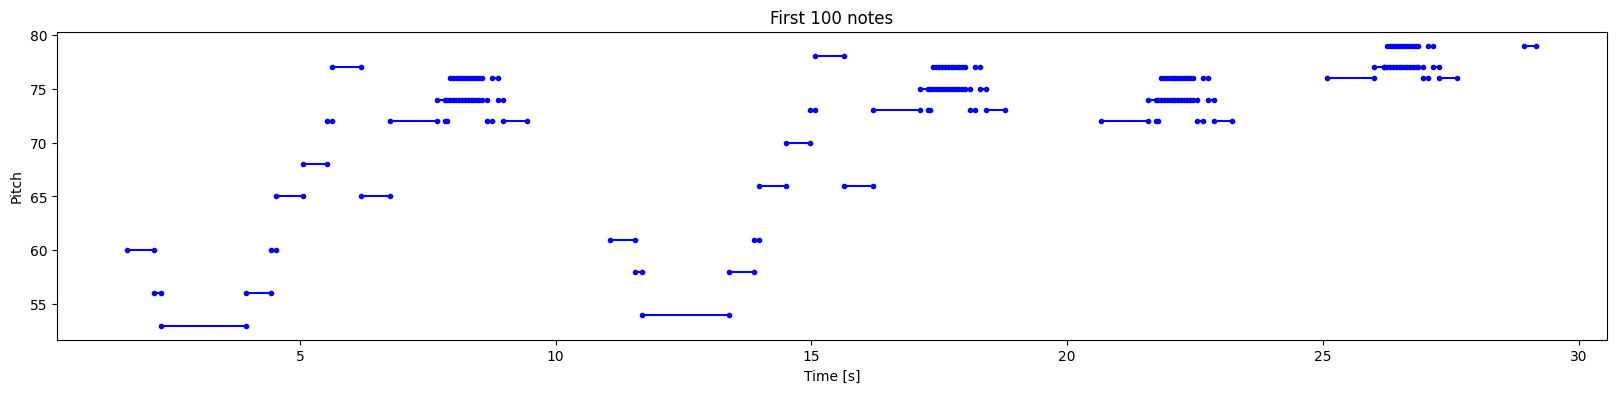

In [26]:
plot_piano_roll(raw_notes, count=100)

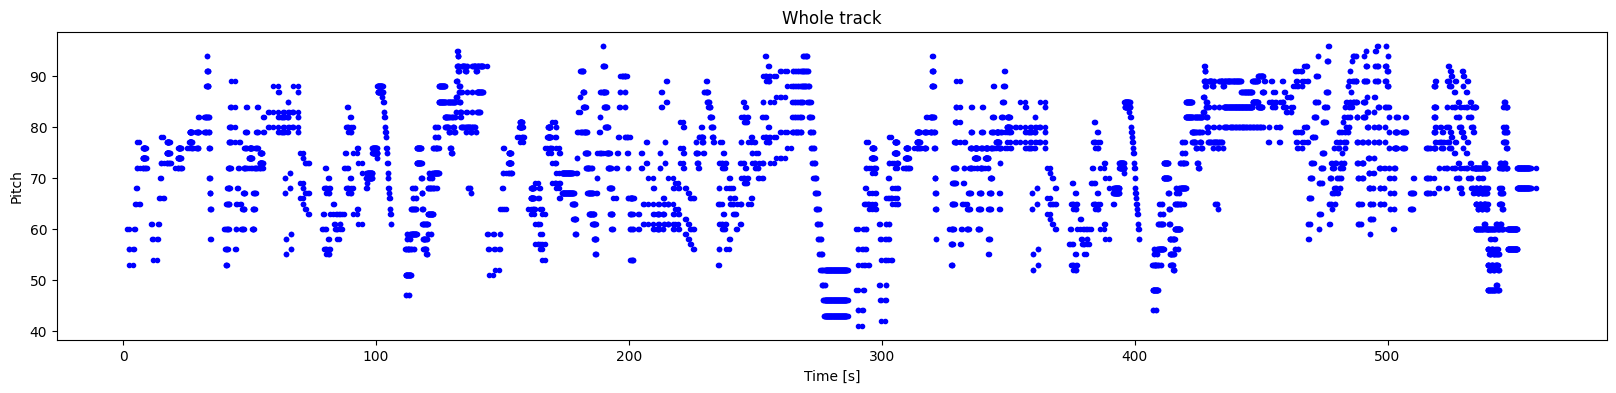

In [27]:
plot_piano_roll(raw_notes)

In [28]:
#function to plot the histogram  ditrubutions of pitch, duration and step
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

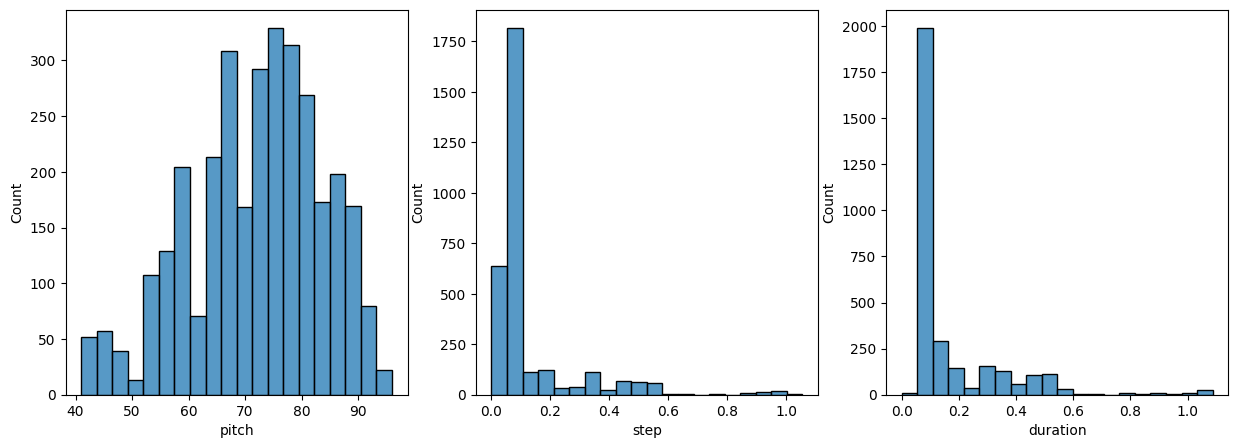

In [29]:
plot_distributions(raw_notes)

#Data Cleaning
converting the previous data into usable data using the pretty midi library to convert files into a trainable format, also dropping values that have corruptions or errors.

In [145]:
num_files = 150
all_notes = []
for f in paths[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [146]:
df = all_notes.dropna()
df

,pitch,start,end,step,duration
0,68,22.976619,24.123677,0.000000,1.147059
1,68,24.123677,24.564854,1.147059,0.441177
2,68,24.564854,28.171131,0.441177,3.606277
3,68,28.171131,29.280040,3.606277,1.108909
4,68,29.280040,29.715201,1.108909,0.435161
...,...,...,...,...,...
1320,81,152.771955,152.871623,0.000000,0.099668
1321,86,152.771955,152.871623,0.000000,0.099668
1322,86,152.871623,152.971291,0.099668,0.099668
1323,81,152.871623,152.971291,0.000000,0.099668


In [147]:
n_notes = len(df)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 192675


seperating the features to be trained on

In [148]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([df[key] for key in key_order], axis=1)

In [149]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [58]:
# function to split the given dataset into  equal sequences for better training performance, also dropping any incomplete sequences
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size : int,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x;

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [150]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [151]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.53125    0.         1.14705883]
 [0.53125    1.14705883 0.4411765 ]
 [0.53125    0.4411765  3.60627708]
 [0.53125    3.60627708 1.108909  ]
 [0.53125    1.108909   0.435161  ]
 [0.53125    0.435161   2.417962  ]
 [0.5390625  2.417962   2.46179867]
 [0.53125    2.46179867 2.50792571]
 [0.515625   2.50792571 1.397543  ]
 [0.5546875  1.397543   1.336005  ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=70.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=3.6764118750000137>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.368778375000005>}


Creating the training data

In [159]:
batch_size = 128
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [153]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

Defining a custom loss function to measure loss, pressurizes the features step and duration to take on positive values

In [63]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Defining and compiling the model

In [64]:
input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = keras.Input(input_shape)
x_in = Sequential([
    (LSTM(128)),
])
x = x_in(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['sequential_1[0][0]']        
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['sequential_1[0][0]']        
                                                                                            

In [65]:
losses = model.evaluate(train_ds, return_dict=True)
losses

832/832 [==============================] - 38s 26ms/step - loss: 6.8683 - duration_loss: 1.1925 - pitch_loss: 4.8542 - step_loss: 0.8216


{'loss': 6.868295669555664,
 'duration_loss': 1.192494511604309,
 'pitch_loss': 4.854218482971191,
 'step_loss': 0.8215833902359009}

reduce any inconsistencies in loss, by tuning loss weights below

In [66]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [67]:
model.evaluate(train_ds, return_dict=True)

832/832 [==============================] - 21s 24ms/step - loss: 2.2568 - duration_loss: 1.1925 - pitch_loss: 4.8542 - step_loss: 0.8216


{'loss': 2.256789207458496,
 'duration_loss': 1.192494511604309,
 'pitch_loss': 4.854218482971191,
 'step_loss': 0.8215833902359009}

In [68]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/Music_Generation',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [88]:
%%time
epochs = 30

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks =callbacks
)

Epoch 1/30
832/832 [==============================] - 58s 69ms/step - loss: 0.9663 - duration_loss: 0.0460 - pitch_loss: 3.1927 - step_loss: 0.7607
Epoch 2/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9637 - duration_loss: 0.0453 - pitch_loss: 3.2078 - step_loss: 0.7580
Epoch 3/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9604 - duration_loss: 0.0451 - pitch_loss: 3.1915 - step_loss: 0.7558
Epoch 4/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9593 - duration_loss: 0.0449 - pitch_loss: 3.1992 - step_loss: 0.7544
Epoch 5/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9538 - duration_loss: 0.0445 - pitch_loss: 3.1867 - step_loss: 0.7499
Epoch 6/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9633 - duration_loss: 0.0451 - pitch_loss: 3.2107 - step_loss: 0.7576
Epoch 7/30
832/832 [==============================] - 55s 66ms/step - loss: 0.9608 - duration_loss: 0.0446 - pit

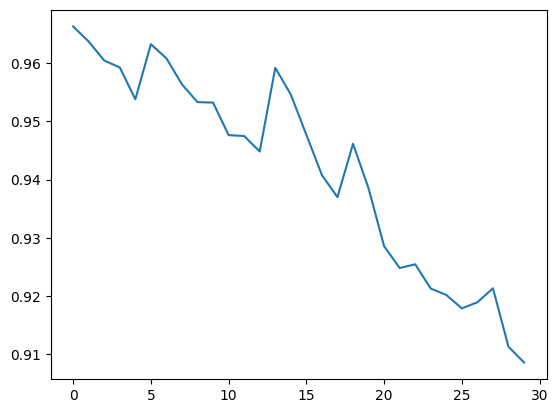

In [92]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [93]:
checkpoint_path = '/content/drive/MyDrive/Music_Generation'
model.load_weights(checkpoint_path)

In [131]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [163]:
temperature = 1.0
num_predictions = 500

sample_notes = np.stack([df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0.0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 24ms/step


In [161]:
generated_notes.head(20)

,pitch,step,duration,start,end
0,72,4.465537,1.166893,4.465537,5.632430
1,89,0.878020,1.053645,5.343557,6.397202
2,86,0.194041,0.409429,5.537598,5.947027
3,96,0.111090,0.365429,5.648688,6.014116
4,94,0.016231,0.317492,5.664919,5.982411
5,89,0.000000,0.284920,5.664919,5.949839
6,99,0.000000,0.264694,5.664919,5.929612
7,93,0.000000,0.297078,5.664919,5.961997
8,98,0.000000,0.268326,5.664919,5.933245
9,94,0.000000,0.288017,5.664919,5.952936


In [99]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [165]:
#unable to generate  large audio files due to RAM crashing
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

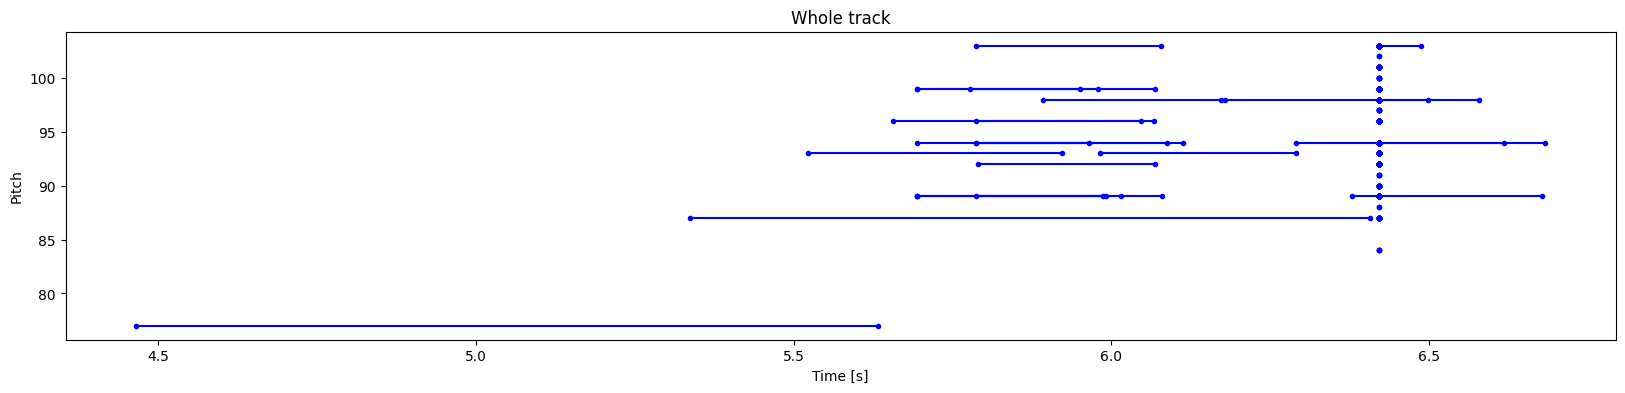

In [164]:
plot_piano_roll(generated_notes)

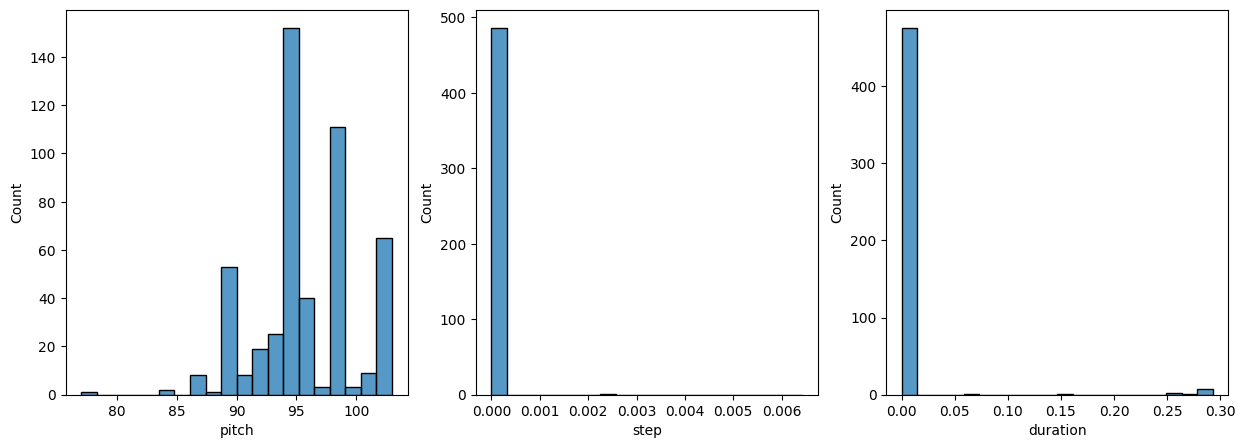

In [166]:
plot_distributions(generated_notes)

In [82]:
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>